1. Import Lib
1. Import Dataset
1. Get Image and Label
1. Create Model
1. Train Model
1. Test Model

# Load Dataset

> Import Lib

In [3]:
import pandas as pd
import torch
import torchvision
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

> Import dataset

load label dataset

In [4]:
label_data = pd.read_csv("../../dataset/facelandmark/facial_keypoints.csv")
label_data = label_data.dropna()
label_index = label_data.index

full_label = label_data.values

load image dataset

In [5]:
image_data = np.load("../../dataset/facelandmark/face_images.npz")
image_data = image_data["face_images"]
image_data = np.transpose(image_data,(2,0,1))

full_image = np.expand_dims(image_data[label_index],1)


> Split dataset train and test

In [45]:
X_train,X_test,y_train,y_test = train_test_split(full_image,full_label,test_size = 10)

> Create class method for Face Dataset

In [6]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self,image,label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = self.image[idx] / 255.
        label = self.label[idx] / 96.
        
        image = torch.as_tensor(image,dtype = torch.float32)
        label = torch.as_tensor(label,dtype = torch.float32)
        
        return image,label
        
        

> test class method

> create dataset

[[[[ 67.  60.  84. ... 132. 143. 137.]
   [ 60.  63.  97. ... 114. 137. 149.]
   [ 61.  69. 106. ... 113. 123. 145.]
   ...
   [108. 106. 107. ... 135. 130. 145.]
   [117. 116. 114. ... 121. 146. 157.]
   [125. 126. 123. ... 144. 153. 153.]]]


 [[[157. 158. 159. ... 161. 159. 159.]
   [160. 157. 158. ... 160. 159. 160.]
   [159. 158. 159. ... 160. 160. 159.]
   ...
   [130. 129. 129. ... 122. 123. 122.]
   [129. 129. 129. ... 122. 123. 122.]
   [127. 129. 129. ... 122. 123. 121.]]]


 [[[232. 233. 233. ... 254. 254. 254.]
   [232. 232. 232. ... 254. 254. 254.]
   [230. 231. 231. ... 254. 254. 254.]
   ...
   [ 87.  87.  76. ...  35.  82.  85.]
   [ 86.  81.  70. ...  32.  68.  96.]
   [ 88.  80.  67. ...  32.  56.  99.]]]


 ...


 [[[111. 108. 120. ... 130. 142. 159.]
   [110. 107. 122. ... 139. 135. 153.]
   [107. 104. 125. ... 145. 135. 138.]
   ...
   [ 79.  79.  78. ...  87.  88.  91.]
   [ 80.  80.  82. ...  88.  96.  93.]
   [ 81.  84.  78. ...  90.  96.  98.]]]


 [[[159. 159.

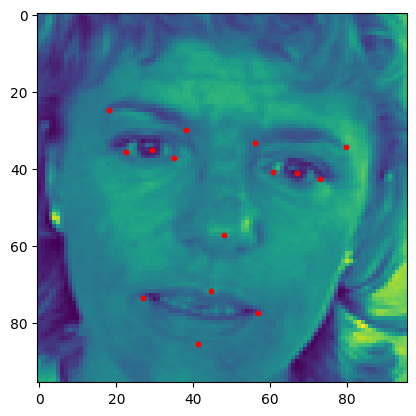

<Figure size 640x480 with 0 Axes>

In [48]:
test_image = FaceDataset(X_train,y_train)

def pltshower(image,label,idx):

    x = label[idx][1].reshape(15,2)[0:,0] *96
    y = label[idx][1].reshape(15,2)[0:,1] *96

    img = image[idx][0]
    img = np.transpose(img,(1,2,0))

    plt.imshow(img)

    plt.scatter(x,y,c = "red", s = 10)
    plt.figure()



for i in range(1):

    pltshower(test_image,test_image,i)



In [8]:
train_loader = torch.utils.data.DataLoader(FaceDataset(X_train,y_train),shuffle = True,batch_size = 32)
test_loader  = torch.utils.data.DataLoader(FaceDataset(X_test,y_test), shuffle = False, batch_size = 32)

# Model Part

> select device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

> load model (our)

In [10]:
class ConvNet(nn.Module):
    def __init__(self,out_class):
        super(ConvNet,self).__init__()
        
        self.conv = nn.Conv2d(1,32,kernel_size = 4)
        self.batch = nn.BatchNorm2d(num_features = 32)
        self.rel = nn.ReLU()
        self.maxp = nn.MaxPool2d(kernel_size = 2)
        self.drop = nn.Dropout(0.6)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size = 4)
        self.batch2 = nn.BatchNorm2d(num_features = 64)
        self.rel2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        self.drop2 = nn.Dropout(0.6)
        
        
        
        self.flat = nn.Flatten()
        self.fc = nn.Linear(64*21*21,out_class)
        
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.rel(x)
        x = self.maxp(x)
        x = self.drop(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        x = self.maxp2(x)
        x = self.drop2(x)
        
        #print(np.shape(x))
        x = self.flat(x)
        x = self.fc(x)
        x = F.sigmoid(x)
        
        return x
        
        

In [11]:
epoch = 30
model = ConvNet(30).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0003)
criterion = nn.L1Loss()



> train

In [14]:
test_loss_graph = []
train_loss_graph = []
for epochs in range(epoch):
    model.train()
    train_loss_inf = 0
    test_loss_inf = 0
    
    for image,label in train_loader:
        
        
        image,label = image.to(device),label.to(device)
        
        output = model(image)
        
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_inf += loss.item() * image.size(0)
    
    model.eval()
    for test_image,test_label in test_loader:
        test_image,test_label = test_image.to(device),test_label.to(device)
        
        output = model(test_image)
        test_loss = criterion(output,test_label)
        
        test_loss_inf += test_loss.item() * test_image.size(0)
    train_loss_graph.append(train_loss_inf / len(X_train)) 
    test_loss_graph.append(test_loss_inf / len(X_test))
    print(f"Epoch: {epochs}/{epoch} Train Loss: {train_loss_inf / len(X_train)}  Test Loss: {test_loss_inf / len(X_test)}")
    torch.save(model.state_dict(),"../../trainedmodel/model.pt")
        

c:\users\saraz\documents\uni\third term\ml\mlproject\venv\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0/30 Train Loss: 0.2929625355194662  Test Loss: 0.2542579569549204
Epoch: 1/30 Train Loss: 0.27141481201596723  Test Loss: 0.2517793220337306
Epoch: 2/30 Train Loss: 0.26885872844099873  Test Loss: 0.2542685114334677
Epoch: 3/30 Train Loss: 0.2635217024901203  Test Loss: 0.2518810798353124
Epoch: 4/30 Train Loss: 0.2572907451095363  Test Loss: 0.23878979320838073
Epoch: 5/30 Train Loss: 0.24983251494039257  Test Loss: 0.23467611166361335
Epoch: 6/30 Train Loss: 0.2317434937257014  Test Loss: 0.2184426595117444
Epoch: 7/30 Train Loss: 0.21527733091315251  Test Loss: 0.19203206520771313
Epoch: 8/30 Train Loss: 0.18233490042844913  Test Loss: 0.1484921665113663
Epoch: 9/30 Train Loss: 0.1347742786675475  Test Loss: 0.10478736265240429
Epoch: 10/30 Train Loss: 0.10887860437915085  Test Loss: 0.08333833954323118
Epoch: 11/30 Train Loss: 0.08883087099495954  Test Loss: 0.0630335337787031
Epoch: 12/30 Train Loss: 0.07290784421987127  Test Loss: 0.05519111611157934
Epoch: 13/30 Train Lo

# Visualize Prediiction

In [12]:
plt.plot(train_loss_graph)
plt.plot(test_loss_graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.suptitle("Loss/Epoch")
plt.legend(["Train","Test"])
plt.figure()

NameError: name 'train_loss_graph' is not defined

> visualize model test

c:\users\saraz\documents\uni\third term\ml\mlproject\venv\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


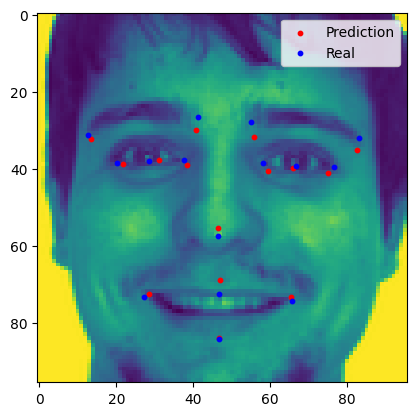

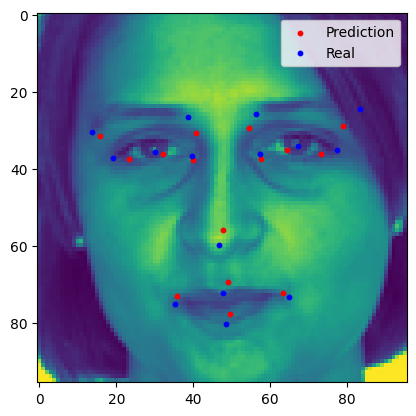

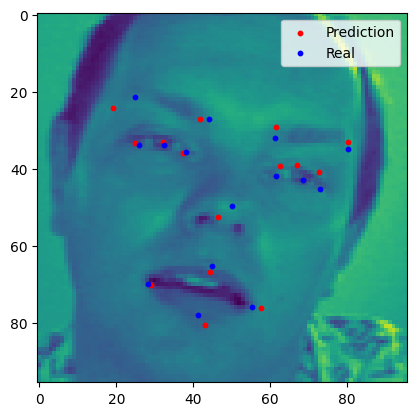

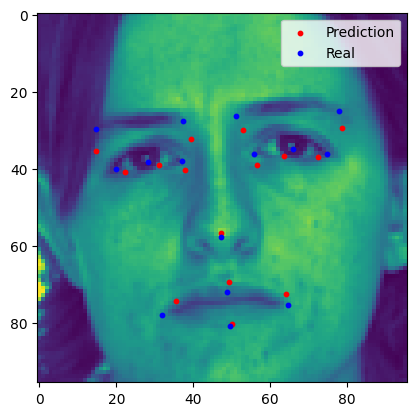

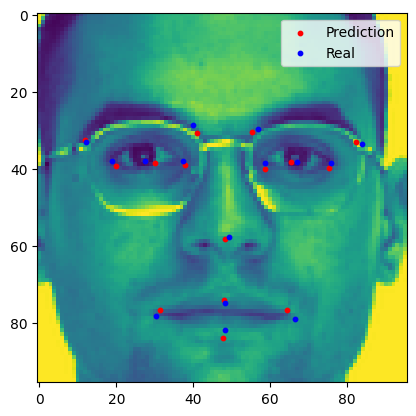

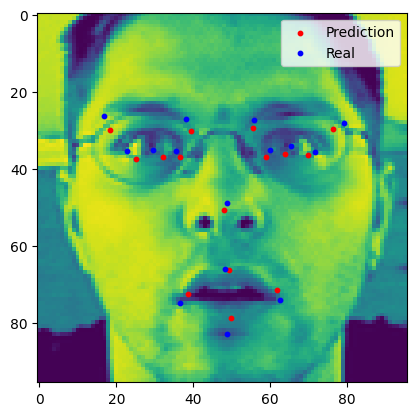

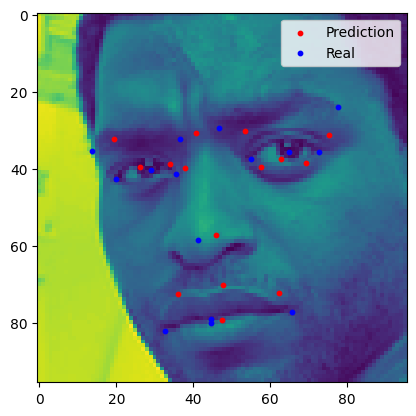

<Figure size 640x480 with 0 Axes>

In [26]:
model = ConvNet(30).to(device)
model.load_state_dict(torch.load('../../trainedmodel/model.pt'))
prediction_result = {}
model = model.to("cpu")

with torch.no_grad():
    
    model.eval()
    for i,(img,label) in enumerate(test_loader):
        output = model(img)

        output = output[i].reshape(15,2)
        real_label = label[i].reshape(15,2)

        # prediction_df = pd.DataFrame(output.reshape(30, 0))
        prediction_df = np.asarray(output.reshape(30, 1))
        prediction_result[i] = prediction_df



        image = img[i]
        image = np.transpose(image,(1,2,0))
        plt.imshow(image*255)
        plt.scatter(output[0:,0]*96,output[0:,1]*96,c="red",s = 10)

        plt.scatter(real_label[0:,0]*96,real_label[0:,1]*96,c="blue",s = 10)
        plt.legend(["Prediction","Real"])#blue : Prediction

        plt.figure()

import csv
with open('prediction.csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
    for key, row in prediction_result.items():
        writer.writerow(iter(row))
